# Chapter 8

## Question 9

Investigating the properties of a single tree fit to the `OJ` dataset, predicting `Purchase` (a categorical)

In [1]:
import statsmodels.api as sm
import sklearn.model_selection
import sklearn.tree
import sklearn.tree.export

import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image


In [2]:
oj_dataset = sm.datasets.get_rdataset("OJ", "ISLR").data
oj_dataset.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


### (a) Create a training set with 800 observations, and a test set with the remainder

In [3]:
X = oj_dataset.drop(columns="Purchase")
# Dummy encode the categorical "Store7"
X = pd.concat([X, pd.get_dummies(X["Store7"], prefix="Store7", drop_first=True)],axis=1).drop(columns="Store7")

y = oj_dataset.Purchase

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=len(oj_dataset)-800)

### (b) Fit a tree to the training data, with `Purchase` as the repsonse. Use the `summary()` function to get summary statistics about the tree, and describe the results. What is the training error rate? How many terminal nodes does the tree have?

In [4]:
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
report = sklearn.metrics.classification_report(y_train, y_pred)
print(report)

print(f"Fraction misclassified: {sklearn.metrics.zero_one_loss(y_train, y_pred):.2f}")

              precision    recall  f1-score   support

          CH       0.99      1.00      0.99       495
          MM       1.00      0.98      0.99       305

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Fraction misclassified: 0.01


In [5]:
n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True


In [6]:
# Summarise the tree

print(f"number of nodes: {tree.tree_.node_count}")
print(f"number of leaves: {sum(is_leaves)}")
print()
counts = np.unique(node_depth,return_counts=True )
for depth, count in zip(*counts):
    print(f"Nodes at depth {depth}: {count}")

number of nodes: 323
number of leaves: 162

Nodes at depth 0: 1
Nodes at depth 1: 2
Nodes at depth 2: 4
Nodes at depth 3: 8
Nodes at depth 4: 14
Nodes at depth 5: 20
Nodes at depth 6: 26
Nodes at depth 7: 40
Nodes at depth 8: 44
Nodes at depth 9: 44
Nodes at depth 10: 30
Nodes at depth 11: 34
Nodes at depth 12: 26
Nodes at depth 13: 20
Nodes at depth 14: 6
Nodes at depth 15: 4


### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed

In [7]:
# This doesn't really apply in Python but we can mimic the functionality.
# The below is not very helpful
print(sklearn.tree.export.export_text(tree, feature_names=list(X_train.columns), max_depth=3))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- StoreID <= 1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- StoreID >  1.50
|   |   |   |   |--- class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- WeekofPurchase >  273.00
|   |   |   |   |--- class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- LoyalCH <= 0.28
|   |   |   |   |--- class: CH
|   |   |   |--- LoyalCH >  0.28
|   |   |   |   |--- truncated branch of depth 12
|   |   |--- PriceDiff >  0.05
|   |   |   |--- WeekofPurchase <= 245.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- WeekofPurchase >  245.50
|   |   |   |   |--- truncated branch of depth 10
|--- LoyalCH >  0.50
|   |--- PriceDiff <= -0.39
|   |   |--- LoyalCH <= 0.65
|   |   |   |--- class: MM
|   |   |--- LoyalCH >  0.65
|   |   |   |--- SpecialCH <= 0.50


In [8]:
feature = tree.tree_.feature
threshold = tree.tree_.threshold

test_node = 4
print(f"If feature {feature[test_node]}: {X.columns[feature[test_node]]} is <= {threshold[test_node]} then \
go to node {children_left[test_node]}, else go to node {children_right[test_node]}")

If feature 0: WeekofPurchase is <= 251.5 then go to node 5, else go to node 6


### (d) Create a plot of the tree, and interpret the results

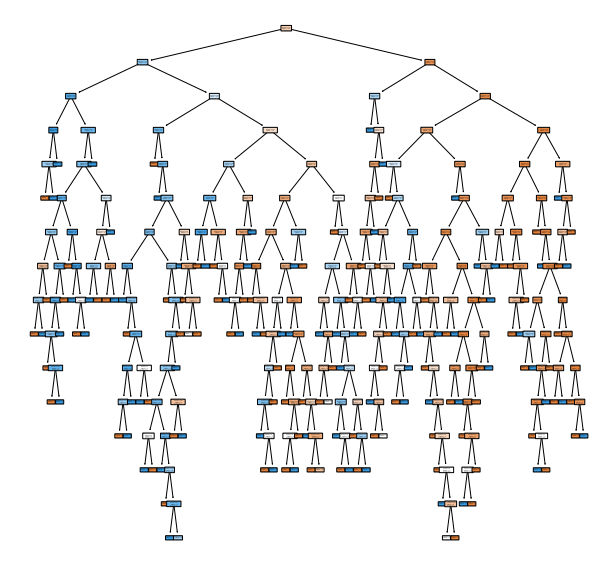

In [9]:
# dot_data = sklearn.tree.export_graphviz(tree, out_file=None, 
#                       feature_names=X_train.columns,  
#                       filled=True, rounded=True,  
#                       special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph.render("tree", format="png")
# Image("tree.png")
fig, ax = plt.subplots(figsize=(10,10))
sklearn.tree.plot_tree(tree, 
                      feature_names=X_train.columns,  
                      filled=True, rounded=True, ax=ax
                      )
plt.show()

### (f)  Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [10]:
y_pred = tree.predict(X_test)
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f"Fraction misclassified: {sklearn.metrics.zero_one_loss(y_test, y_pred):.2f}")

[[117  41]
 [ 29  83]]
Fraction misclassified: 0.26


### (f) Apply the `cv.tree()` function to the training set in order to determine the optimal tree size

In [11]:
# Again, not possible here. Use GridSearchCV. There are lots of ways you could interpret "tree size"
parameters = {'max_leaf_nodes':range(5,200,5), "max_depth": range(1,20)}
clf = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv=5)
clf.fit(X=X_train, y=y_train)
best_tree = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8175 {'max_depth': 4, 'max_leaf_nodes': 10}


In [12]:
y_pred = best_tree.predict(X_test)
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f"Fraction misclassified: {sklearn.metrics.zero_one_loss(y_test, y_pred):.2f}")

[[130  28]
 [ 27  85]]
Fraction misclassified: 0.20


### (g) Produce a plot of tree size against cross-validated error rate. 

In [13]:
cv_results = pd.DataFrame(clf.cv_results_)[["param_max_depth", "param_max_leaf_nodes", "mean_test_score", "std_test_score"]]

In [14]:
cv_results.head()

,param_max_depth,param_max_leaf_nodes,mean_test_score,std_test_score
0,1,5,0.7975,0.013463
1,1,10,0.7975,0.013463
2,1,15,0.7975,0.013463
3,1,20,0.7975,0.013463
4,1,25,0.7975,0.013463


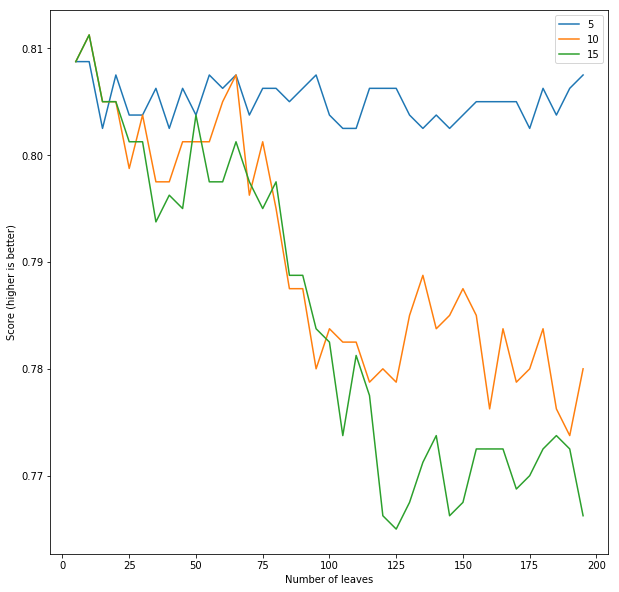

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
for depth in [5,10,15]:  # set(cv_results.param_max_depth): # including all the results is a bit messy
    ax.errorbar("param_max_leaf_nodes",
                 "mean_test_score",
#                  yerr="std_test_score",
                 data=cv_results[cv_results["param_max_depth"] == depth],
                 label=depth)
ax.legend()
ax.set_ylabel("Score (higher is better)")
ax.set_xlabel("Number of leaves")
plt.show()

### (h) Which tree size corresponds to the lowest cross-validated error rate?

In [16]:
print(f"A tree of depth {clf.best_params_['max_depth']} and with a maximum  of {clf.best_params_['max_leaf_nodes']} leaf nodes is best.")

A tree of depth 4 and with a maximum  of 10 leaf nodes is best.


### (i) Produce a tree corresponding to this optimal tree size

In [17]:
best_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [18]:
y_pred = tree.predict(X_train)
print(f"Unpruned tree: Fraction misclassified (training): {sklearn.metrics.zero_one_loss(y_train, y_pred):.2f}")
y_pred = best_tree.predict(X_train)
print(f"Pruned tree: Fraction misclassified (training): {sklearn.metrics.zero_one_loss(y_train, y_pred):.2f}")

Unpruned tree: Fraction misclassified (training): 0.01
Pruned tree: Fraction misclassified (training): 0.15


### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [19]:
y_pred = tree.predict(X_test)
print(f"Unpruned tree: Fraction misclassified (training): {sklearn.metrics.zero_one_loss(y_test, y_pred):.2f}")
y_pred = best_tree.predict(X_test)
print(f"Pruned tree: Fraction misclassified (training): {sklearn.metrics.zero_one_loss(y_test, y_pred):.2f}")

Unpruned tree: Fraction misclassified (training): 0.26
Pruned tree: Fraction misclassified (training): 0.20
